In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import operator
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import datasets  
from sklearn.ensemble import RandomForestClassifier
from numpy import argmax
from sklearn import metrics  
from sklearn.tree import plot_tree
from sklearn import tree

In [2]:
path = r'/Users/yourname/Datasets'

In [4]:
tf.random.set_seed(42)

In [5]:
signals = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [6]:
activities = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

In [7]:
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

def load_signals(subset):
    signals_data = []

    for signal in signals:
        filename = f'{path}/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).to_numpy()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'{path}/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).to_numpy()

def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [8]:
X_train, X_test, y_train, y_test = load_data()

In [9]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7352, 128, 9) (7352, 6)
(2947, 128, 9) (2947, 6)


In [10]:
#The X shape needs to be (22950, 15, 9)
X_train = X_train.reshape(-1,1152) #-1 means "whatever works"
print(X_train.shape)
X_train

(7352, 1152)


array([[ 1.808515e-04,  1.076681e-02,  5.556068e-02, ...,  1.021171e+00,
        -1.213260e-01,  9.498741e-02],
       [ 1.093752e-03, -4.687588e-03, -2.685954e-02, ...,  1.017849e+00,
        -1.305193e-01,  9.061235e-02],
       [ 3.531266e-03,  4.455942e-03, -5.914581e-03, ...,  1.022019e+00,
        -1.301826e-01,  8.148748e-02],
       ...,
       [-2.267175e-01,  5.684462e-02,  2.289274e-01, ...,  7.767680e-01,
        -3.275988e-01,  1.886212e-01],
       [-6.480597e-02, -5.740777e-03,  3.102535e-01, ...,  7.193530e-01,
        -2.291273e-01,  2.100712e-01],
       [-1.944707e-01, -9.723743e-02,  2.030342e-01, ...,  8.002428e-01,
        -3.323721e-01, -8.357159e-02]])

In [11]:
y_train

array([[0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0]], dtype=uint8)

In [12]:
#Use argmax to get rid of on-hot encoding and supply the numerical value.
y_train = np.argmax(y_train, axis = 1)
print(y_train.shape)
y_train

(7352,)


array([4, 4, 4, ..., 1, 1, 1], dtype=int64)

In [13]:
#The X shape needs to be (22950, 15, 9)
X_test = X_test.reshape(-1,1152) #-1 means "whatever works"
print(X_test.shape)
X_test

(2947, 1152)


array([[ 0.01165315, -0.02939904,  0.1068262 , ...,  0.9943906 ,
        -0.2641348 ,  0.1454939 ],
       [ 0.00927963,  0.00665052, -0.02631933, ...,  0.9928615 ,
        -0.2799715 ,  0.1213135 ],
       [ 0.00573194,  0.00730484,  0.01021286, ...,  0.9882446 ,
        -0.2822329 ,  0.1321175 ],
       ...,
       [-0.1476465 ,  0.00551979,  0.01025031, ...,  0.8504963 ,
        -0.4900368 ,  0.1378256 ],
       [ 0.07122683, -0.1498122 , -0.1659306 , ...,  1.323546  ,
        -0.3472416 , -0.2760682 ],
       [-0.1936425 , -0.1907511 ,  0.1958357 , ...,  0.9578348 ,
        -0.1941603 , -0.02892477]])

In [14]:
y_test = np.argmax(y_test, axis = 1)
print(y_test.shape)
y_test

(2947,)


array([4, 4, 4, ..., 1, 1, 1], dtype=int64)

In [15]:
len(X_train[0])

1152

In [26]:
# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 100)#, max_depth=5)  
  
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train, y_train)

RandomForestClassifier()

In [27]:
# performing predictions on the test dataset
y_pred = clf.predict(X_test)
  
# using metrics module for accuracy calculation
print("Model Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Model Accuracy:  0.8479809976247031


In [18]:
act = ['WALKING',
       'WALKING_UPSTAIRS',
       'WALKING_DOWNSTAIRS',
       'SITTING',
       'STANDING',
       'LAYING'
      ]

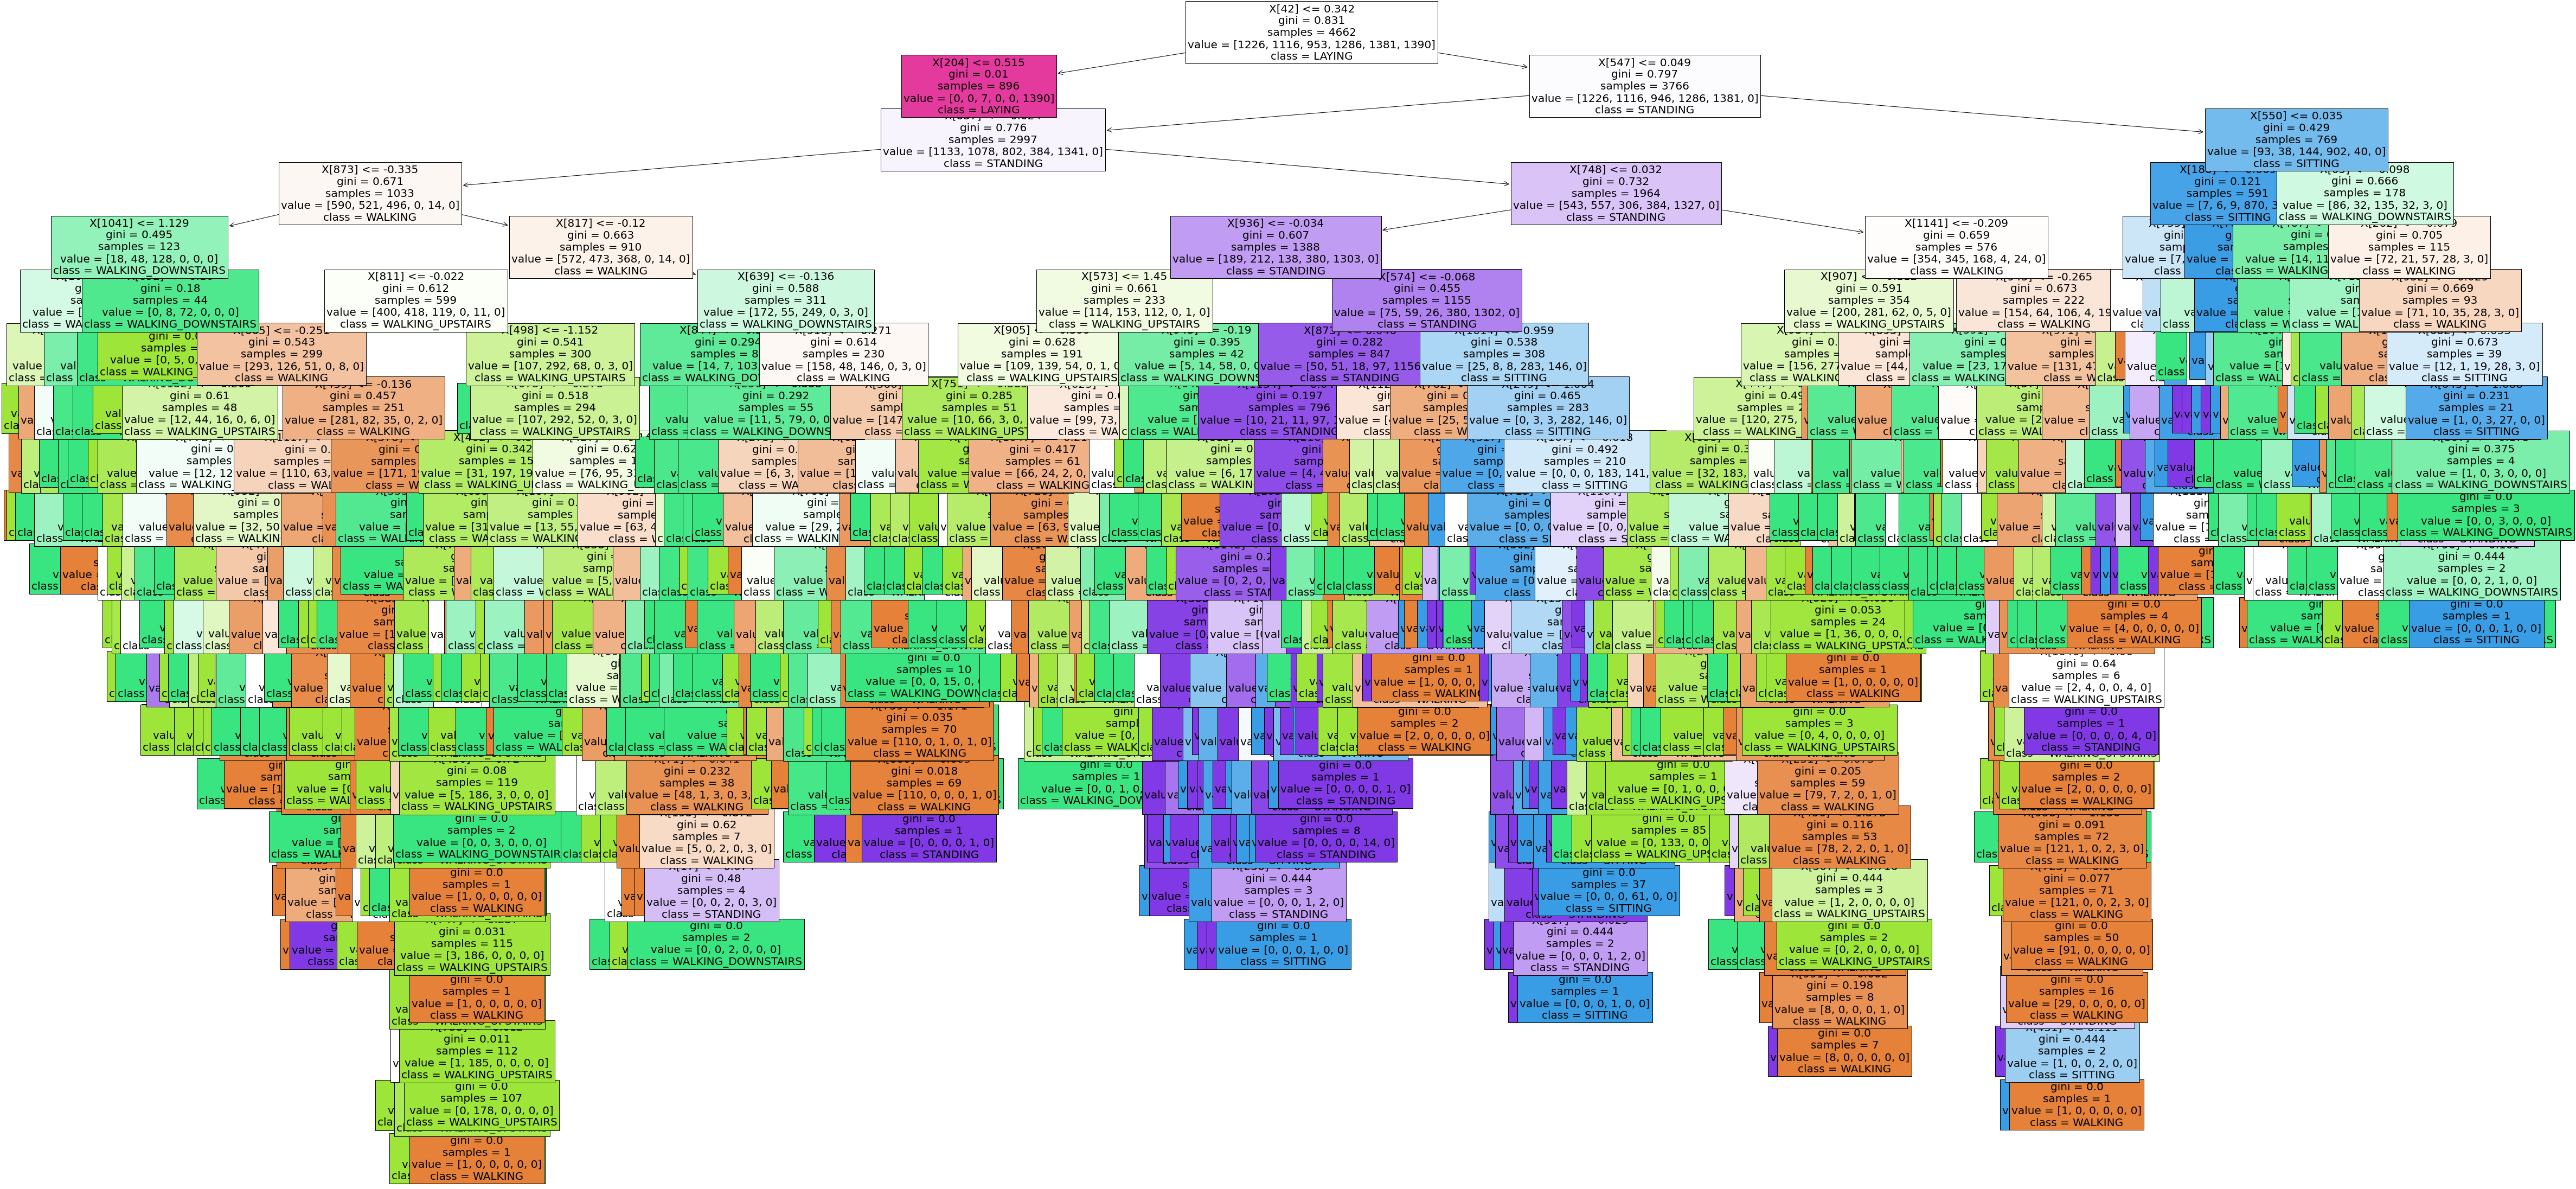

In [28]:
fig = plt.figure(figsize=(80,40))
plot_tree(clf.estimators_[15], fontsize = 20, class_names=act, filled=True);#, feature_names = X.columns,class_names=['Disease', "No Disease"],filled=True); max_depth = 4, 

In [29]:
fig.savefig(f"{path}/decision_tree.png")

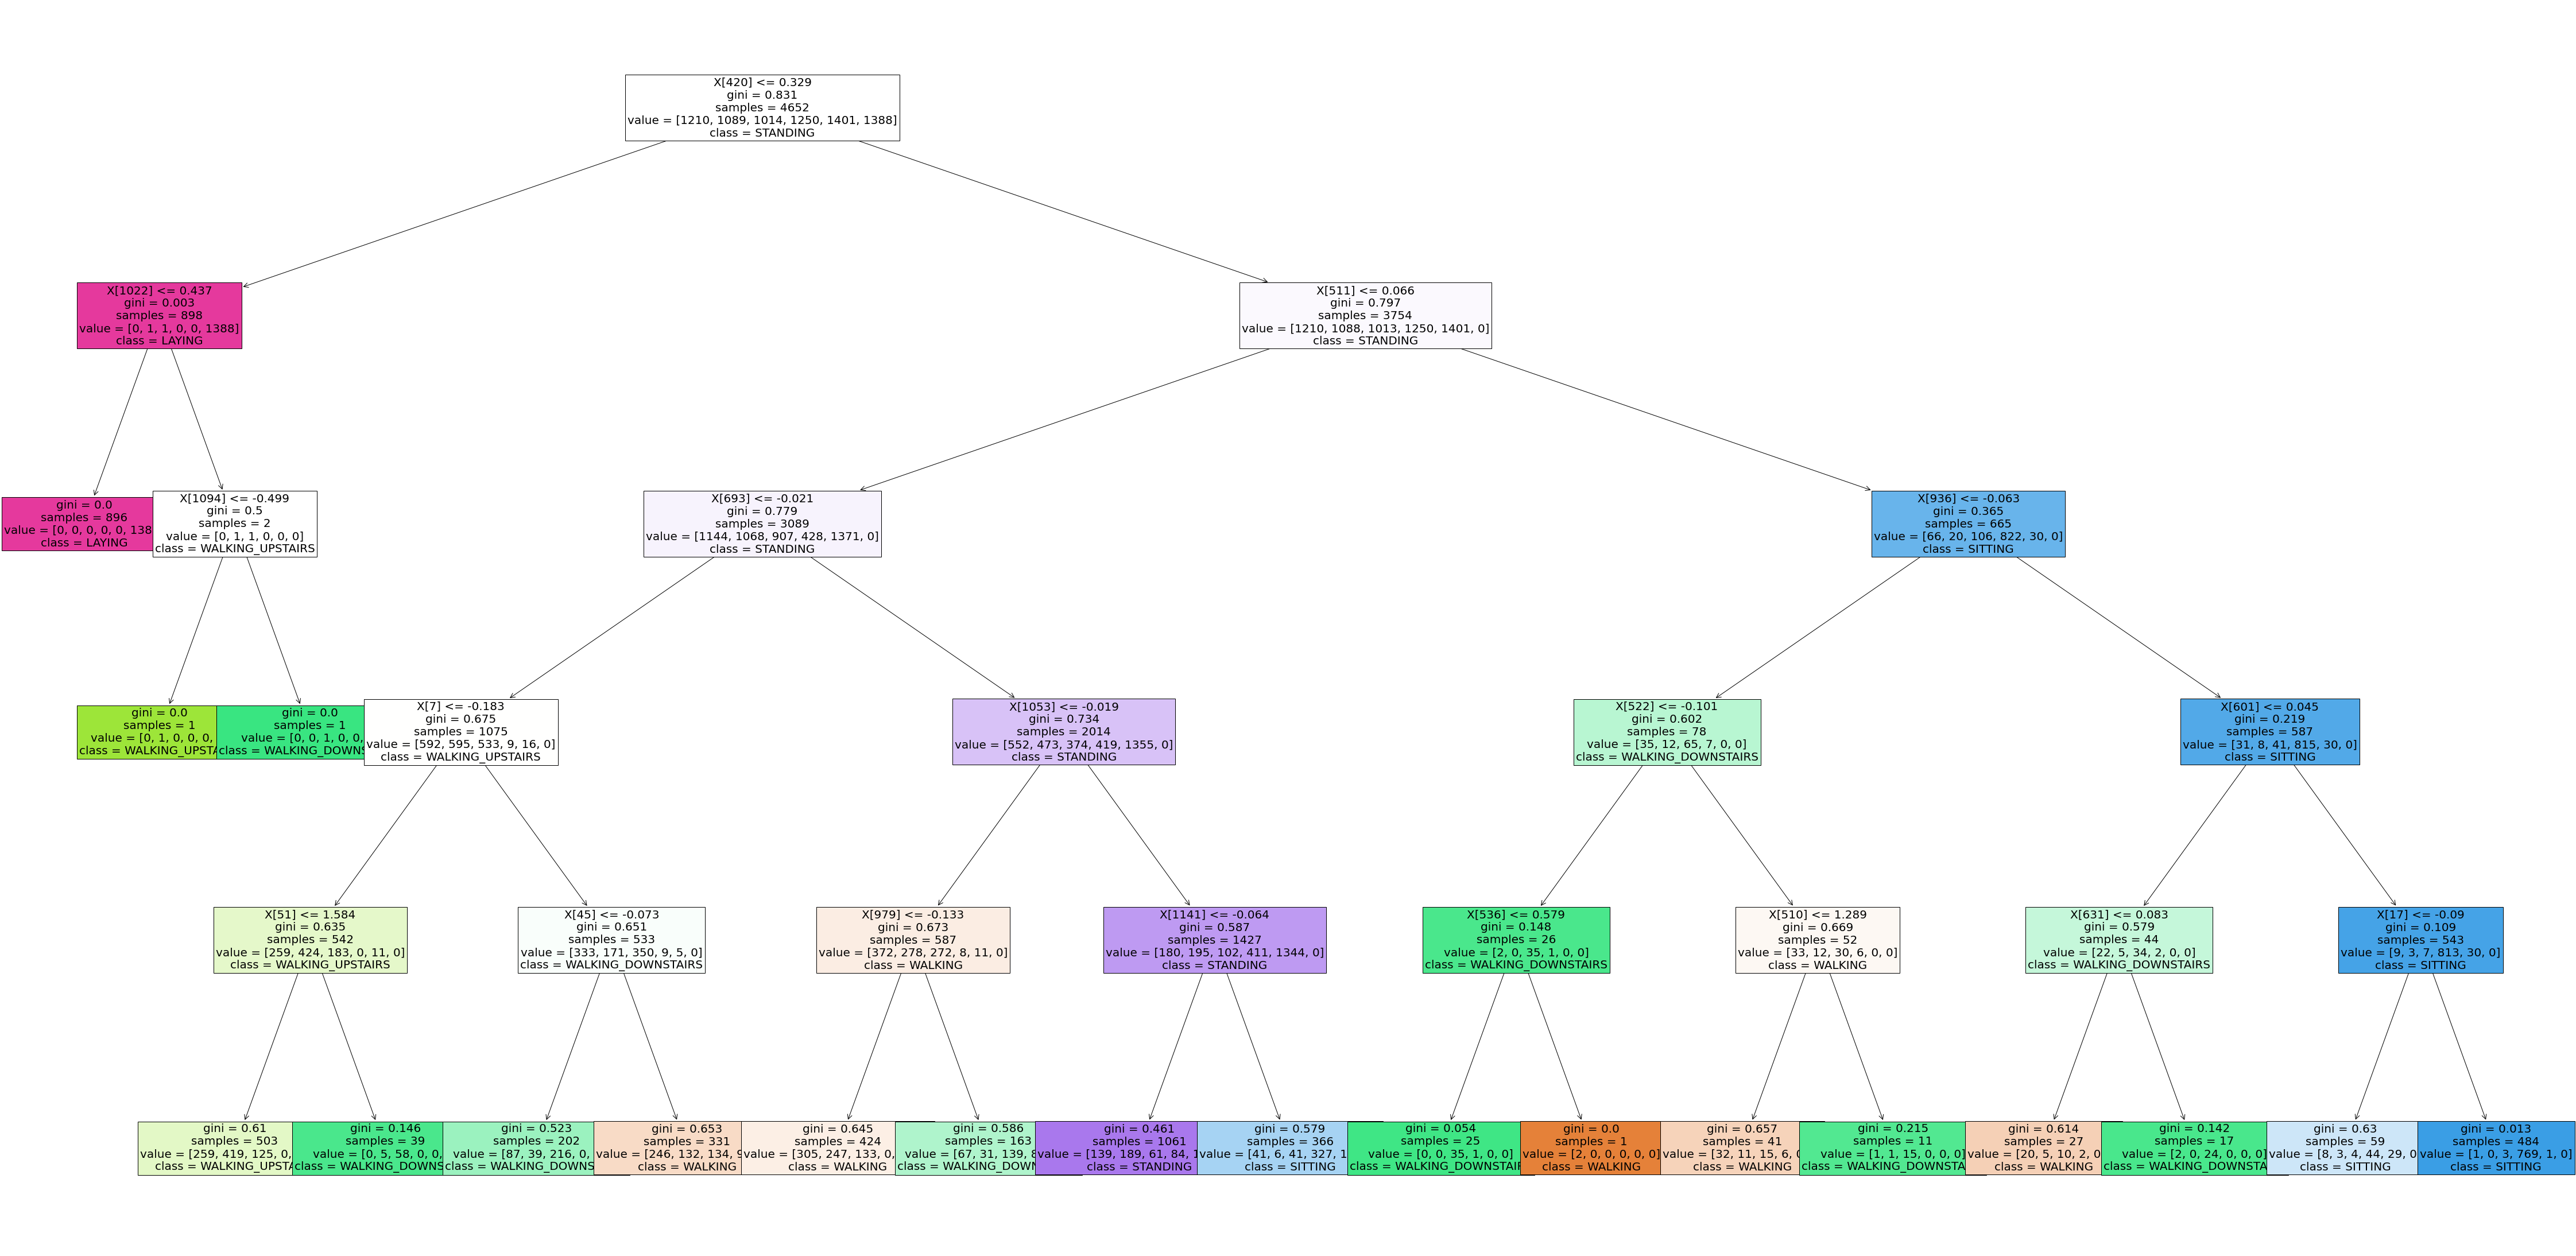

In [21]:
fig = plt.figure(figsize=(80,40))
plot_tree(clf.estimators_[99], fontsize = 20, class_names=act, filled=True);

In [76]:
np.set_printoptions(threshold=np.inf)
newarray = clf.feature_importances_
#print(clf.feature_importances_.shape)
newarray

array([1.10403641e-03, 1.96895584e-04, 2.41578633e-04, 3.24564683e-04,
       2.44407504e-04, 1.61346806e-04, 6.01168790e-04, 1.33079771e-03,
       2.62480153e-04, 5.81819270e-04, 1.68819343e-04, 1.56762189e-04,
       2.40257496e-04, 1.07712154e-04, 1.46883398e-04, 6.20284170e-04,
       8.05191931e-04, 3.09107010e-04, 1.43063514e-03, 4.84795272e-04,
       1.61803227e-04, 2.53306523e-04, 1.95202725e-04, 2.47571964e-04,
       3.04944596e-04, 1.44108521e-03, 2.68758924e-04, 2.72462619e-04,
       2.10698595e-04, 2.59495931e-04, 2.34294261e-04, 1.73731456e-04,
       3.35533117e-04, 2.73510857e-03, 1.84484403e-03, 2.44358338e-04,
       1.12592280e-03, 2.03343749e-04, 2.18269895e-04, 5.38396510e-04,
       1.11639841e-04, 1.88401318e-04, 2.68932961e-03, 2.47950321e-03,
       4.89165318e-04, 8.60405803e-04, 1.23596230e-04, 1.59479525e-04,
       2.91413009e-04, 1.89576852e-04, 2.01648476e-04, 2.73965734e-03,
       8.92793837e-04, 2.75507980e-04, 5.36266988e-04, 1.52860501e-04,
      

In [77]:
np.set_printoptions(threshold=1000)

In [78]:
newarray = newarray.reshape(-1,128,9)
print(newarray.shape)
newarray

(1, 128, 9)


array([[[0.00110404, 0.0001969 , 0.00024158, ..., 0.00060117,
         0.0013308 , 0.00026248],
        [0.00058182, 0.00016882, 0.00015676, ..., 0.00062028,
         0.00080519, 0.00030911],
        [0.00143064, 0.0004848 , 0.0001618 , ..., 0.00030494,
         0.00144109, 0.00026876],
        ...,
        [0.00125086, 0.00022529, 0.00018666, ..., 0.00499393,
         0.00159868, 0.00040961],
        [0.00046146, 0.0001795 , 0.00024375, ..., 0.00120549,
         0.00258075, 0.00040396],
        [0.00122065, 0.00020583, 0.00025065, ..., 0.00286662,
         0.00350703, 0.00051372]]])

In [80]:
sumarray = np.sum(newarray[0], axis=0)
sumarray

array([0.19347533, 0.0409192 , 0.03243853, 0.03745625, 0.02740251,
       0.03945084, 0.34410623, 0.23679407, 0.04795705])

In [82]:
important = pd.Series(sumarray, index = signals) #.sort_values(ascending = False)
important

body_acc_x     0.193475
body_acc_y     0.040919
body_acc_z     0.032439
body_gyro_x    0.037456
body_gyro_y    0.027403
body_gyro_z    0.039451
total_acc_x    0.344106
total_acc_y    0.236794
total_acc_z    0.047957
dtype: float64

['body_acc_x', 'body_acc_y', 'body_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z', 'total_acc_x', 'total_acc_y', 'total_acc_z']


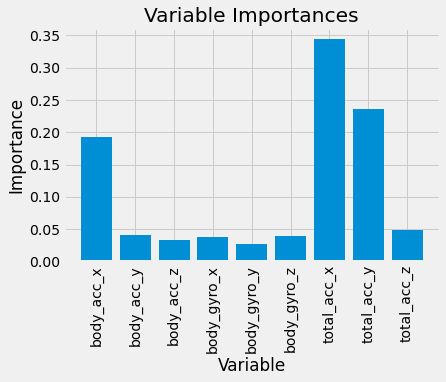

In [83]:
%matplotlib inline

plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(important)))
print(signals)

plt.bar(x_values, important, orientation = 'vertical')
plt.xticks(x_values, signals, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');